In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
from cmcrameri import cm

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings

In [2]:
ds = xr.open_dataset(Path('../bedmap3_mod.nc'))

In [3]:
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)

print(f'{np.count_nonzero(np.isnan(ds.thick_cond.values) & ice_rock_msk):,} grid cells to simulate at 500 m resolution')

41,970,733 grid cells to simulate at 500 m resolution


# 41 million cells to simulate at 500 m resolution

In [4]:
bed_cond = ds.surface_topography.values - ds.thick_cond.values
xx, yy = np.meshgrid(ds.x, ds.y)

In [5]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

x_cond.shape, x_cond[::1000].shape

((7410163,), (7411,))

## Add BM3 streamline thickness to conditioning data

In [6]:
%%time

pts = gpd.read_file(Path(r'D:\bm3_streamlines_pt\bm3_streamlines_pt.shp'))

coords = pts.get_coordinates()
coords = (np.rint(coords['x'].values), np.rint(coords['y'].values))
thick = pts.thick.values

xx, yy = np.meshgrid(ds.x, ds.y)

dist_msk = vd.distance_mask(coords, 1e3, (xx, yy))

kn = vd.KNeighbors(k=1)
kn.fit(coords, thick)
preds = kn.predict((xx[dist_msk], yy[dist_msk]))

stream_thick = np.full(xx.shape, np.nan)
np.place(stream_thick, dist_msk, preds)

new_thick_cond = np.where(np.isnan(stream_thick), ds.thick_cond.values, stream_thick)

ds['thick_cond'] = (('y', 'x'), new_thick_cond)

CPU times: total: 8min 37s
Wall time: 8min 37s


In [8]:
def xy_into_grid(gridx, gridy, coords, values, fill=np.nan, quiet=False):
    """
    Place tabular data that is colocated with grid coordinates inside of grid.

    Args:
        ds : xarray.Dataset with grid coordinates
        coords : tuple of tabular coordinates, e.g., (x, y)
        values : tuple of values correspondin to coords, e.g., (var1, var2)
        fill : value to fill in grid where there are no values
        quiet : show progress bar if False
    Outputs:
        if multiple arrays in values, returns a tuple of gridded values, 
        otherwise returns single gridded array
    """
    if gridx[0] > gridx[1]:
        gridx = np.sort(gridx)
        reversex = True
    else:
        reversex = False
    if gridy[0] > gridy[1]:
        gridy = np.sort(gridy)
        reversey = True
    else:
        reversey = False
    
    values = np.array(values)
    if len(values.shape)==1:
        values = np.expand_dims(values, axis=0)
        
    arr = np.full((len(values), len(gridy), len(gridx)), fill)
    
    for i in tqdm(range(len(coords[0])), disable=quiet):
        xi = coords[0][i]
        yi = coords[1][i]
        xind = np.searchsorted(gridx, xi)
        yind = np.searchsorted(gridy, yi)
        if (xind < len(gridx)) & (yind < len(gridy)):
            if (gridx[xind] == xi) & (gridy[yind] == yi):
                if reversex == True:
                    xind = len(gridx) - xind - 1
                if reversey == True:
                    yind = len(gridy) - yind - 1
                arr[:,yind, xind] = values[:,i].squeeze()
    if arr.shape[0]>1:
        return tuple(arr)
    else:
        return arr.squeeze()

In [9]:
stream_thick2 = xy_into_grid(ds.x.values, ds.y.values, coords, thick)

  0%|          | 0/258721 [00:00<?, ?it/s]

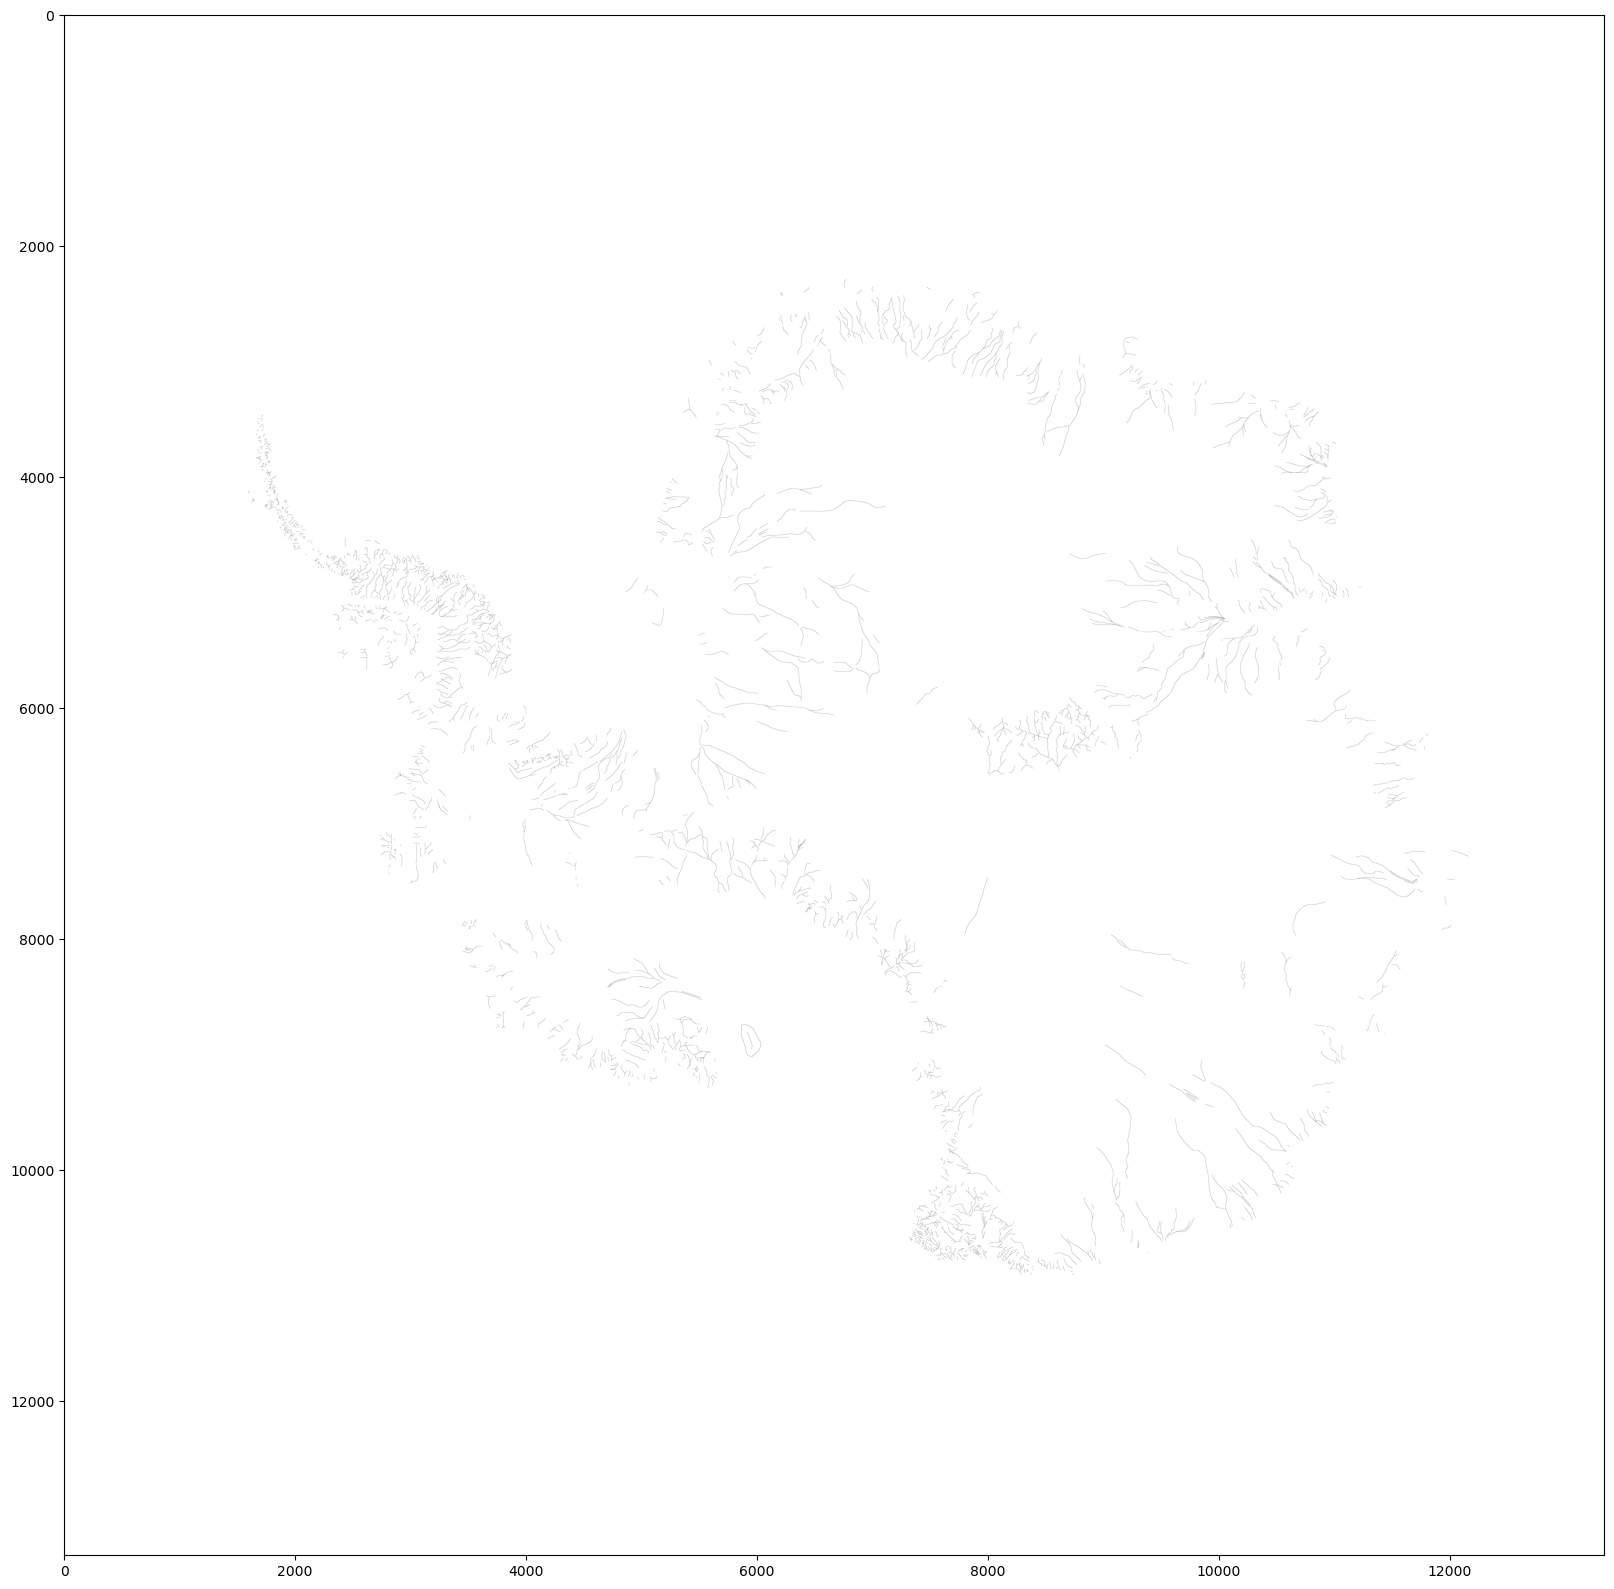

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(stream_thick2)
plt.show()

In [11]:
def spline_interp_msk(points, values, xx, yy, mask, damping):
    sp = vd.Spline(damping=damping)
    sp.fit((points[:,0], points[:,1]), values)
    preds = sp.predict((xx[mask], yy[mask]))
    grid = np.full(xx.shape, np.nan)
    np.place(grid, mask, preds)
    return grid

In [18]:
%%time

trend2 = spline_interp_msk(np.array([x_cond[::1000], y_cond[::1000]]).T, data_cond[::1000], xx, yy, 
                           ice_rock_msk, damping=1e-5)

CPU times: total: 2h 9min 47s
Wall time: 8min 21s


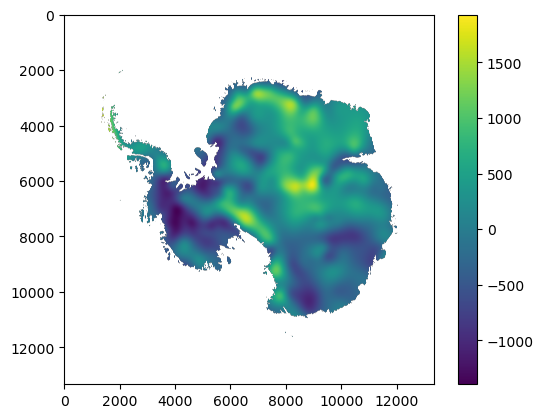

In [19]:
plt.imshow(trend2)
plt.colorbar()
plt.show()

## Trend (takes about 7 minutes)

In [24]:
%%time

smoothing = 1e11
interp = RBFInterpolator(np.array([x_cond[::1000], y_cond[::1000]]).T, data_cond[::1000], smoothing=smoothing)
trend = interp(np.array([xx[ice_rock_msk].flatten(), yy[ice_rock_msk].flatten()]).T)

CPU times: total: 2h 50min 41s
Wall time: 1h 13min 31s


In [25]:
trend_grid = np.full(bed_cond.shape, np.nan)
np.place(trend_grid, ice_rock_msk, trend)
res_cond = bed_cond - trend_grid

In [20]:
res_cond = bed_cond - trend2

MemoryError: Unable to allocate 1.32 GiB for an array with shape (13334, 13334) and data type float64

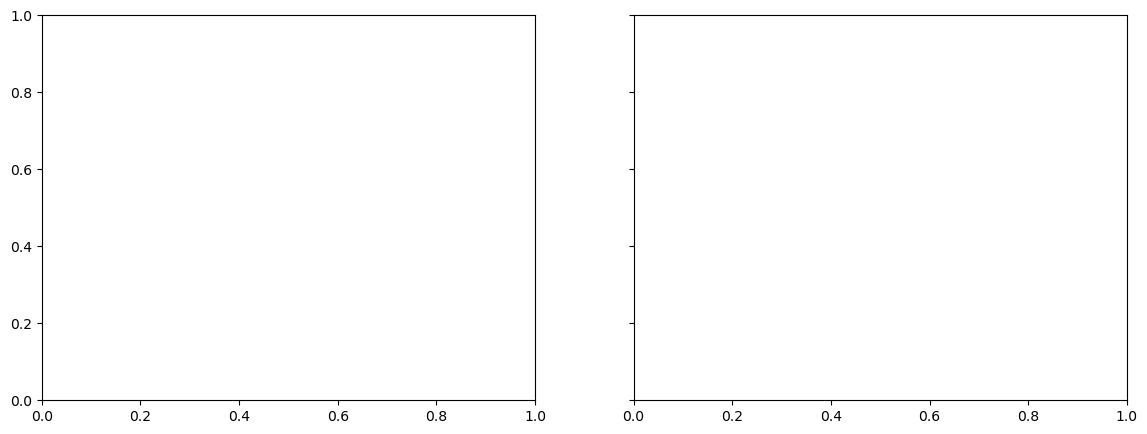

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend2)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Residual')

plt.show()

In [27]:
ds['trend'] = (('y', 'x'), trend_grid)
ds.to_netcdf(Path('../bedmap3_mod_500m.nc'))

# Coarsen to 1 km resolution

In [28]:
ds = ds.coarsen(x=2, y=2, boundary='trim').median()
ds['mask'] = (('y', 'x'), np.where(np.isnan(ds.mask.values), np.nan, np.rint(ds.mask.values).astype(int)))

C:\Users\mjfie\AppData\Local\Temp\ipykernel_31184\2877956523.py:2: RuntimeWarning: invalid value encountered in cast
  ds['mask'] = (('y', 'x'), np.where(np.isnan(ds.mask.values), np.nan, np.rint(ds.mask.values).astype(int)))


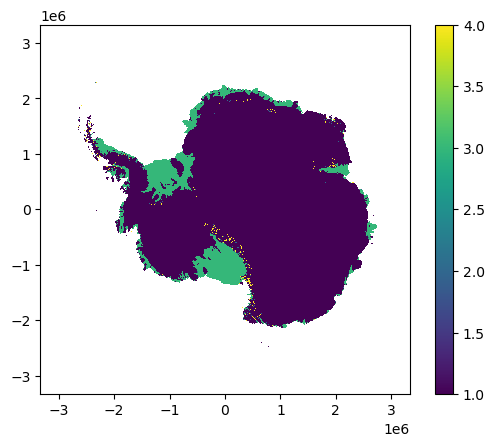

In [29]:
plt.pcolormesh(ds.x, ds.y, ds.mask.values)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [30]:
ds.y.values.size * ds.x.values.size

44448889

In [31]:
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)

print(f'{np.count_nonzero(np.isnan(ds.thick_cond.values) & ice_rock_msk):,} grid cells to simulate at 1 km resolution')

9,526,916 grid cells to simulate at 1 km resolution


# 9,740,284 simulation points at 1 km resolution

In [32]:
ds.to_netcdf(Path('../bedmap3_mod_1km.nc'))